# Regression

In the previous exercises, we learned basic signal processing techniques. We will apply those techniques in today's exercise on regression-based EMG signal to hand movement decoding.

Regression is a good candidate for the scenarios where decoding the user's motor intentions in a continuous fashion is desirable. 

The dataset used here is subject1's data in the first database from the Ninapro dataset (https://ninapro.hevs.ch/instructions/DB1.html). 

This dataset includes detailed information about finger angles. Our objective now is to predict these finger angles using the EMG data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

Download the dataset and check the data structure.

In [2]:
data = loadmat("S1_A1_E1.mat")
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
emg
stimulus
glove
subject
exercise
repetition
restimulus
rerepetition


Now, load in the EMG data. Take only the part of EMG data where the index finger is involved in movements (part 1 and 2 that correspond to index flexion and index extension, see https://ninapro.hevs.ch/instructions/DB1.html). Check the data structure printing data dimension and type.

In [3]:
emg_data = data["emg"]
# only take the part of the data where index is involved in movements
data_index_where_movement_ends = 19_000
emg_data = emg_data[:data_index_where_movement_ends,:]
print("EMG data dimension: {}".format(emg_data.shape))
print("EMG data type: {}".format(type(emg_data)))

EMG data dimension: (19000, 10)
EMG data type: <class 'numpy.ndarray'>


Load in hand kinematics labels. Select only the joint angles associated to the index finger movement (6 and 7, see the glove image here https://ninapro.hevs.ch/instructions/DB1.html). Take only the part of data labels where index finger is involved in movement (see cell above). Check the data structure printing data dimension and type.

In [4]:
# only regressing on finger joint 6 and 7
glove_data_index = data["glove"][:data_index_where_movement_ends, 5:7]
print("Glove data dimension: {}".format(glove_data_index.shape))
print("Glove data type: {}".format(type(glove_data_index)))

Glove data dimension: (19000, 2)
Glove data type: <class 'numpy.ndarray'>


Text(0, 0.5, 'Amplitude')

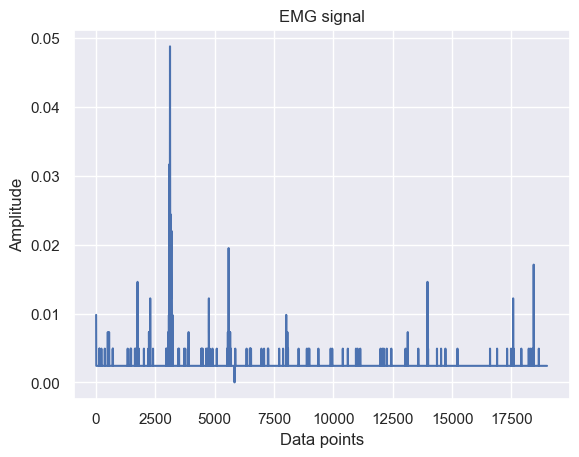

In [5]:
# Plot first channel to get a sense of the data
plt.close("all")
fig, ax = plt.subplots()
ax.plot(emg_data[:, 5])   
ax.set_title("EMG signal")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

We can see when the channel is picking up signals from the muscles. Let's check the signal quality to decide on the signal processing techniques.

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

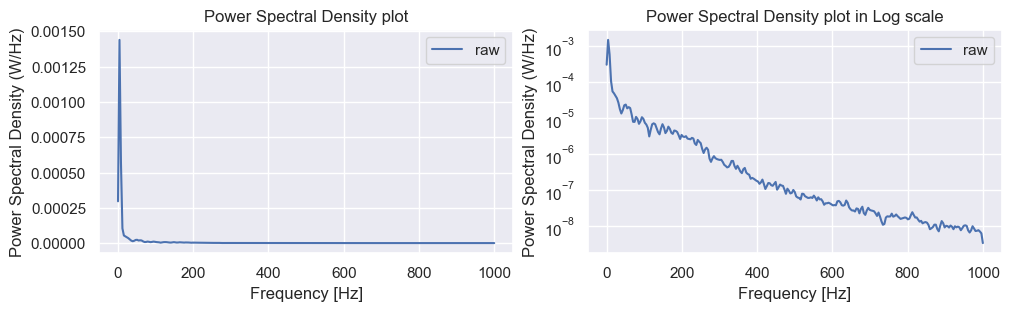

In [6]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg_data[:, 8], fs=2000, nperseg=512)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

The signal seems to be minimally influenced by the powerline noise. Therefore, we can save the powerline filtering and proceed directly with the enveloping.

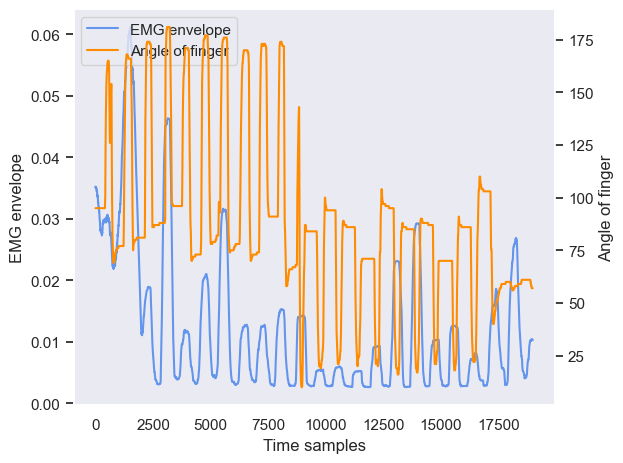

In [7]:
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes = convolve1d(emg_data, weights=mov_mean_weights, axis=0)

fig, ax = plt.subplots()
ax.plot(EMG_envelopes[:, 0],color = 'cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

finger_angle_ax = ax.twinx()
finger_angle_ax.plot(glove_data_index[:, 0], color="darkorange", label="Angle of finger")
finger_angle_ax.set_ylabel("Angle of finger")
finger_angle_ax.grid(False)

# Get handles and labels for legend
emg_handles, emg_labels = ax.get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

# Combine handles and labels
combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

# Create a single legend
ax.legend(combined_handles, combined_labels, loc='upper left')
plt.tight_layout()

To process the dataset efficiently, we divide it into overlapping sliding windows. This approach allows us to extract smaller segments of the EMG data, each corresponding to a specific time interval. The sliding window technique ensures that we capture temporal patterns in the signal by dividing it into time segments, while maintaining continuity through overlapping segments.

In [8]:
fs = 2000  # [Hz], from dataset description
emg_window_length_sec = 50e-3  # [s]
incremental_window_length_sec = 10e-3  # [s]

In [21]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        if i % 500_0000 == 0:
            print(f"steps{i}", start_points[i], end_points[i], end_points[i] - start_points[i])
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [22]:
from sklearn.model_selection import train_test_split
# extract over lapping time windows on the whole dataset before splitting the dataset into train, validation and test
EMG_windows, Labels_windows = extract_time_windows_regression(EMG_envelopes, glove_data_index, fs, emg_window_length_sec, incremental_window_length_sec)

# randomly pick data for train, validation and test
EMG_train_windows, EMG_test_windows, Labels_train_windows, Labels_test_windows = train_test_split(EMG_windows, Labels_windows, test_size=0.2, random_state=151)

print(f"EMG train data shape: {EMG_train_windows.shape}, Train label shape: {Labels_train_windows.shape}")
print(f"EMG test data shape: {EMG_test_windows.shape}, Test label shape: {Labels_test_windows.shape}")

steps0 0 100 100
EMG train data shape: (756, 100, 10), Train label shape: (756, 100, 2)
EMG test data shape: (189, 100, 10), Test label shape: (189, 100, 2)


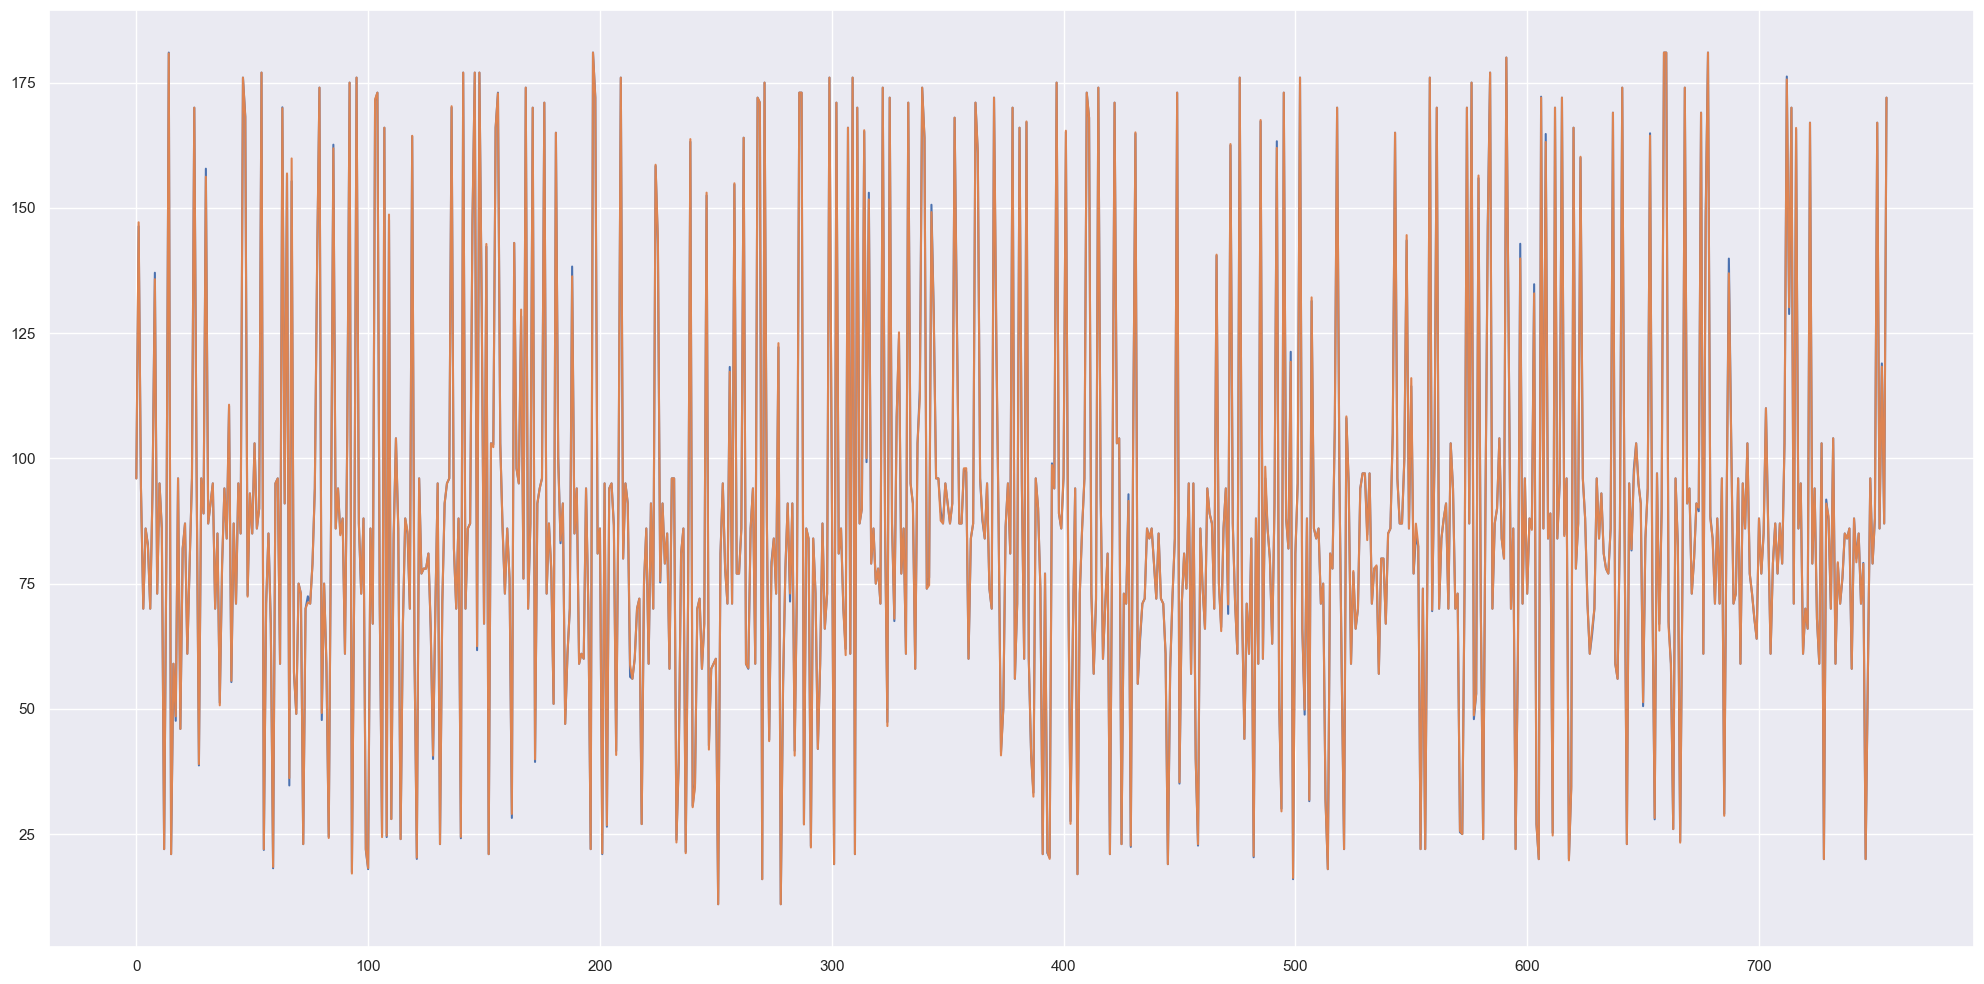

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(Labels_train_windows[:, :2, 0])
plt.tight_layout()

Now that we have the windows, lets extract some features again. For this exercise, we will just look at the mean and std of the windows.

In [12]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    # along axis 1, which is the time axis
    EMG_mean = np.mean(EMG_windows, axis=1)
    EMG_std = np.std(EMG_windows, axis=1)
    EMG_max_amplitude = np.max(EMG_windows, axis=1)
    Labels_mean = np.mean(Labels_windows,axis=1)
    
    # Concatenate the mean and std of each window
    EMG_extracted_features = np.concatenate((EMG_mean, EMG_std, EMG_max_amplitude), axis=1)
    return EMG_extracted_features, Labels_mean

In [13]:
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows,Labels_train_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows,Labels_test_windows)

print("EMG train extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG test extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

EMG train extracted features shape: (756, 30), Fingler labels feature shape:(756, 2)
EMG test extracted features shape: (189, 30), Fingler labels feature shape:(189, 2)


Next, we'll focus on the regressor. Scikit-learn greatly simplifies the process, whether you're working with classification or regression tasks. The key is ensuring your data is in a format compatible with the library. Once that's achieved, switching between different algorithm types to suit your data becomes straightforward. The workflow is quite similar across various algorithms: you start by fitting the model to your training data, and then proceed to make predictions on the test set.

In [14]:
#Fit and predict using the linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(GradientBoostingRegressor())
model.fit(EMG_train_extracted_features, Labels_train_mean)

# Predict
y_pred = model.predict(EMG_test_extracted_features)

In [15]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
   'estimator__n_estimators': [100, 200, 300],
   'estimator__learning_rate': [0.01, 0.1],
   'estimator__max_depth': [3, 5, 7],
   'estimator__min_samples_split': [2, 5],
   'estimator__subsample': [0.8, 1.0]
}

base_model = GradientBoostingRegressor(random_state=42)
model = MultiOutputRegressor(base_model)

grid_search = GridSearchCV(
   estimator=model,
   param_grid=param_grid,
   cv=5,
   n_jobs=-1,
   verbose=2,
   scoring='neg_mean_squared_error'
)

grid_search.fit(EMG_train_extracted_features, Labels_train_mean)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.1],
                         'estimator__max_depth': [3, 5, 7],
                         'estimator__min_samples_split': [2, 5],
                         'estimator__n_estimators': [100, 200, 300],
                         'estimator__subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

It's crucial to quantify the model's performance using appropriate metrics. Take a look at scikit-learn's model evaluation (https://scikit-learn.org/stable/modules/model_evaluation.html), there are many metrics that we can choose. The more common ones are MSE, RMSE, MAE. For this exercise, we can take a look at MSE. 

In [16]:
from sklearn.metrics import mean_squared_error

# Compute the mean squared error
MSE = mean_squared_error(y_pred, Labels_test_mean)

print(f'MSE of Linear Regression: {MSE}')

MSE of Linear Regression: 68.24252855342357


In [17]:
from sklearn.metrics import mean_squared_error

# Compute the mean squared error
MSE = mean_squared_error(y_pred, Labels_test_mean)

print(f'MSE of Gradien Boosting: {MSE}')

MSE of Gradien Boosting: 68.24252855342357


Check prediction accuracy in finger angle 6:

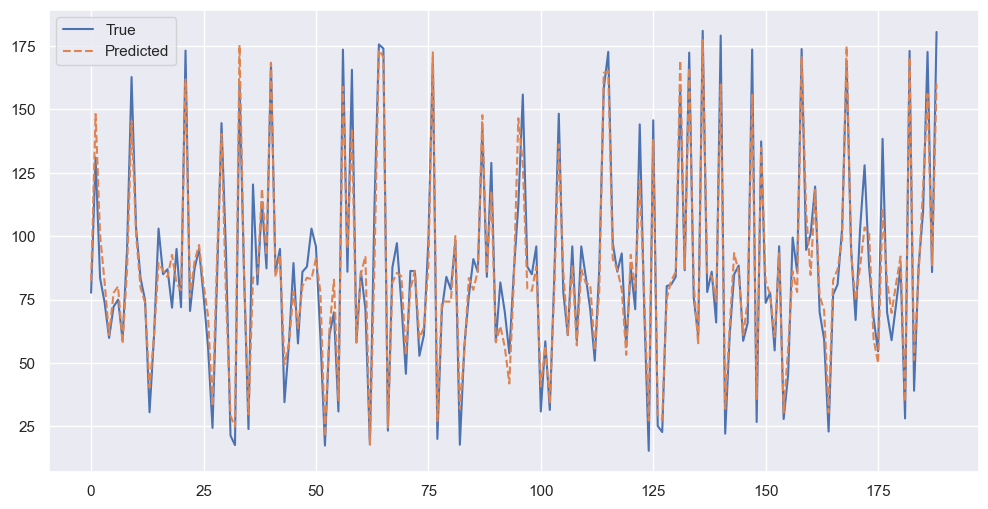

In [18]:
# Plot the true and predicted values for finger angle 6
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Labels_test_mean[:,0], label="True")
ax.plot(y_pred[:,0], linestyle="--", label="Predicted")
ax.legend()

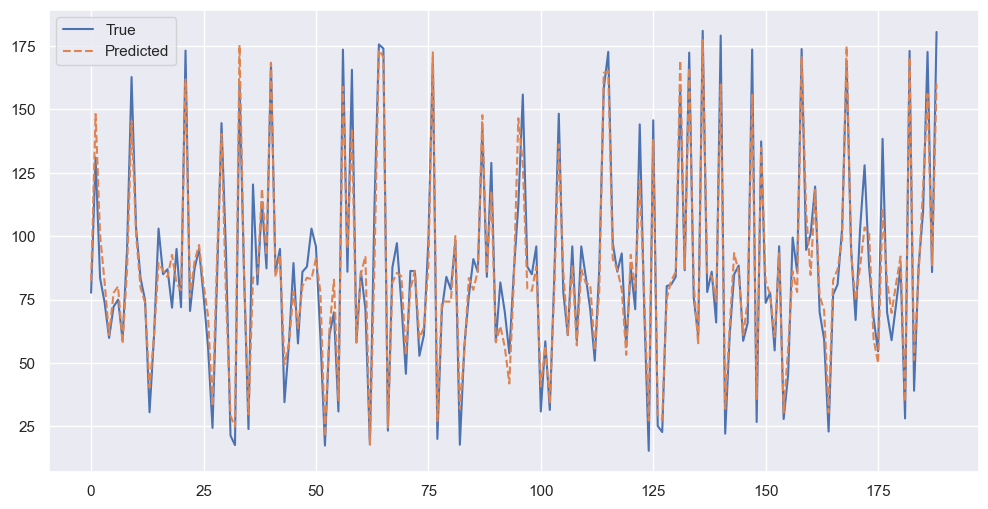

In [19]:
# Plot the true and predicted values for finger angle 6
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Labels_test_mean[:,0], label="True")
ax.plot(y_pred[:,0], linestyle="--", label="Predicted")
ax.legend()

Check prediction accuracy in finger angle 7:

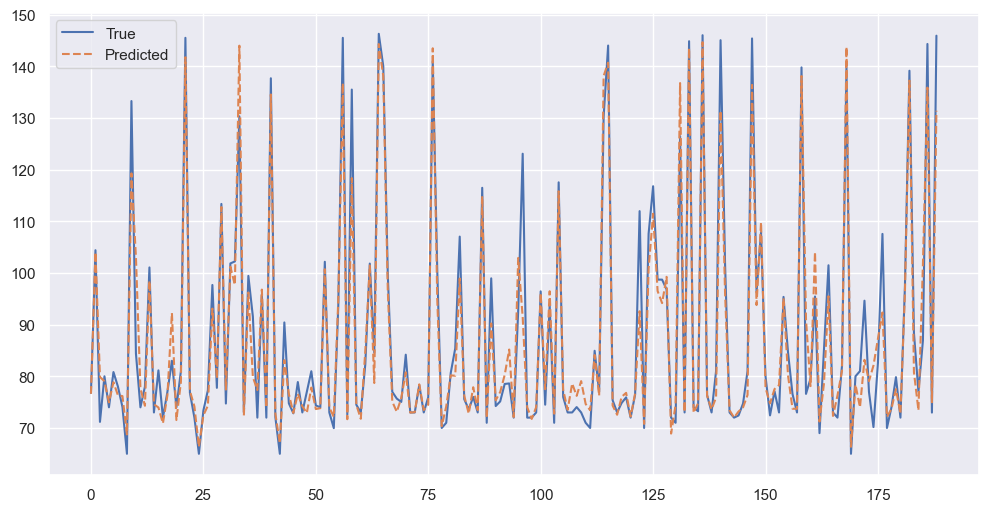

In [20]:
# Plot the true and predicted values for finger angle 7
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Labels_test_mean[:,1], label="True")
ax.plot(y_pred[:,1], linestyle="--", label="Predicted")
ax.legend()

Now you can try any other regression models, and compare the performances between each others.